# Wingsail Controller Prototype

In [56]:
# Install Python dependencies
!pip3 install numpy scipy matplotlib


Defaulting to user installation because normal site-packages is not writeable


In [57]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math


## Function `compute_reynolds_number` Implementation

It takes the apparent wind speed and the chord width to computes the Reynold's number. 

$$Re = \frac{V_{app}c}{k}$$

where $V_{app}$ is the apparent wind speed, $c$ is the chord width of the mainsail, and $k$ is the kinematic viscosity of air. The kinematic viscosity is a constant value of $1.5 \times 10^{-5} \frac{m^2}{s}$, and the chord width is a constant value of $14 cm$ obtained from mech's design.

```python

In [58]:
CHORD_WIDTH_MAIN_SAIL = 0.14  # meters, trim tab chord width is not included
KINEMATIC_VISCOSITY = 0.000014207  # {m^2 / s at 10degC} and air density at 1.225 {kg / m^3}


def compute_reynolds_number(apparent_wind_speed):
    """
    Computes the Reynolds number for the main sail.

    Parameters:
    - apparent_wind_speed (float): The apparent wind speed in meters per second.

    Returns:
    - reynolds_number (float): The computed Reynolds number for the main sail.
    """
    reynolds_number = (apparent_wind_speed * CHORD_WIDTH_MAIN_SAIL) / KINEMATIC_VISCOSITY
    return reynolds_number


## Function `compute_angle_of_attack` Implementation

It takes the Reynolds number and uses a lookup table to find the angle of attack.

In [59]:
def compute_angle_of_attack(reynolds_number, look_up_table):
    """
    Computes the desired angle of attack based on Reynolds number and a lookup table.

    Parameters:
    - reynolds_number (float): The Reynolds number.
    - look_up_table: A 2D numpy array containing Reynolds numbers in the first column
      and corresponding desired angles of attack in the second column.

    Returns:
    - desired_alpha (float): The computed desired angle of attack based on the provided Reynolds number
      and lookup table.
    """
    desired_alpha = np.interp(reynolds_number, look_up_table[:, 0], look_up_table[:, 1])
    return desired_alpha


## Function `compute_trim_tab_angle` Implementation

It takes the desired alpha value and computes the resulting trim tab angle. 

Computes the trim tab angle based on the desired angle of attack and the apparent wind direction. apparent_wind_direction will use degrees and follow same convention of WindSensor.msg (increases CW). Zero degrees means that the apparent wind is blowing from the bow to the stern of the boat. 

The reason that the trim tab is equal to the desired_alpha mirrored about the apparent wind direction is because the the wind will push the trim tab, effectively rotating the mainsail until the trim tab is in line with the apparent wind (The mainsail sits on a bearing and will not rotate unless the trim tab is being pushed by the wind). This means that if we want to rotate the mainsail x degrees, we need to rotate the trim tab -x degrees. 

In [60]:
def compute_trim_tab_angle(desired_alpha, apparent_wind_direction):
    """
    Range: -180 < direction <= 180 for symmetry

    Parameters:
    - desired_alpha (float): The desired angle of attack.
    - apparent_wind_direction (float): The apparent wind direction in degrees.

    Returns:
    - trim_tab_angle (float): The computed trim tab angle based on the provided desired angle of attack,
      apparent wind direction, and boat direction.

    """
    return math.copysign(desired_alpha, apparent_wind_direction)


## Test `test_trim_tab_angle`:

Takes in apparent wind speed, apparent wind direction and the look up table of reynolds values and angles of attack. It then computes the reynolds number, followed by the and the angle of attack (alpha value). It then computes the trim tab angle and prints it.


In [61]:
def test_trim_tab_angle(apparent_wind_speed, apparent_wind_direction, look_up_table):
    """_summary_

    Parameters:
        apparent_wind_speed (float): the apparent wind speed of the boat
        apparent_wind_direction (float): apparent wind direction in degrees
        look_up_table (float, float): a 2D array containing Reynolds numbers in the first column
        and corresponding desired angles of attack in the second column
    """
    reynolds = compute_reynolds_number(apparent_wind_speed)
    alpha = compute_angle_of_attack(reynolds, look_up_table)
    trim_tab_angle = compute_trim_tab_angle(alpha, apparent_wind_direction)

    print("Reynolds number: ", round(reynolds, 2))
    print("Angle of attack: ", round(alpha, 2))
    print("Trim tab angle: ", round(trim_tab_angle, 2))


## Reynolds to Alpha Lookup Table
lookup_table is a table that pairs reynolds numbers with angles of attack. The reynolds numbers are the keys and the angles of attack are the values. This table is sourced from [MECH testing](https://docs.google.com/spreadsheets/d/1rQuq55-VvUJRCS3mtuV4XycXq11VGx2vdJTXsl3EVNs/edit#gid=0) and is likely more accurate then the computations that would be done instead.

| Reynolds Number | Angle of Attack |
|-----------------|-----------------|
| 50,000          | 5.75            |
| 100,000         | 6.75            |
| 200,000         | 7.00            |
| 500,000         | 9.75            |
| 1,000,000       | 10.00           |

## Different Apparent Wind Speeds and Apparent Wind Directions as Inputs

The following tests print the trim tab angle, Reynolds number, and angle of attack based on the provided inputs.


In [62]:
apparent_wind_speed = 14.2  # m/s
apparent_wind_direction = -23  # degrees
look_up_table = np.array(
    [[50000, 5.75], [100000, 6.75], [200000, 7], [500000, 9.75], [1000000, 10]]
)  # reynolds number, angle of attack

test_trim_tab_angle(apparent_wind_speed, apparent_wind_direction, look_up_table)


Reynolds number:  139931.02
Angle of attack:  6.85
Trim tab angle:  -6.85


In [63]:
apparent_wind_speed = 100  # m/s
apparent_wind_direction = 40  # degrees
look_up_table = np.array(
    [[50000, 5.75], [100000, 6.75], [200000, 7], [500000, 9.75], [1000000, 10]]
)  # reynolds number, angle of attack

test_trim_tab_angle(apparent_wind_speed, apparent_wind_direction, look_up_table)


Reynolds number:  985429.72
Angle of attack:  9.99
Trim tab angle:  9.99


## Boat Diagram

### Function definitions
`angle` and `windDirection` parameters are values given in degrees and uses left hand coordinate system where positive 
angles represent clockwise rotation on the plot.

`point` and `center` are 2 element arrays that represent a point on an XY cartesian plane. The plot used has the origin
of the cartesian plane in the middle of the plot. Rhe x and y axis are the horizontal and vertical axises respectively.
The first element represents the x value of the point while the second element represents the y value of the point.

`obj` and `sail` are arrays of points (2 element arrays). These arrays represent objects that will be drawn on the plot.
These arrays are iterated over and have a line from one point element to the next point element. The `sail` array has
two sections, the main sail and the trim tab. The trim tab is represented by the last two points of the `sail` array.
This convention is why the method `rotate_trimtab` exists. 

In [64]:
def rotatePointAroundPoint(point, center, angle):
    """
    Returns a point represented by 2 element array (e.g. [x, y]) rotated around a center point
    by angle in degrees. Rotation is done by translating point using center:
    `translated_point` = `point` - `center`

    then applies the rotation matrix:
    `rotated_translated_point` = `rotation_matrix` @ `translated_point`

    then translating the rotated point by center
    `rotated_point` = `rotated_translated_point` + `center`

    Parameters:
        point (array): Point that will be rotated.
        center (array): point used as center of rotation for point.
        angle (float): angle in degrees to rotate point.

    Returns:
        rotated_point (array): Point that has been rotated.
    """

    point = np.array(point)
    center = np.array(center)

    angle = math.radians(angle)
    # angle = (angle / 360) * 2 * 3.14159 * -1

    rotation_matrix = np.array(
        [[np.cos(angle), np.sin(angle)], [-1 * np.sin(angle), np.cos(angle)]]
    )

    translated_point = point - center
    rotated_point = rotation_matrix @ translated_point
    rotated_point = rotated_point + center

    return rotated_point


def rotate_object_around_origin(obj, angle):
    """
    Returns an object, represented by an array of points, with each point rotated around the
    origin by angle degrees.

    Parameters:
        obj (array): Array of points that represents an object.
        angle (float): angle in degrees to rotate object.

    Returns:
        obj (array): Array of points that represents an object, reach point rotated around the
        origin.
    """
    for i in range(len(obj)):
        obj[i] = rotatePointAroundPoint(obj[i], [0, 0], angle)
    return obj


def rotate_trimtab(sail, angle):
    """
    Returns an sail object, represented by an array of points, with the last point rotated around
    the second to last point by angle degrees.

    Parameters:
        sail (array): Array of points that represents a sail object.
        angle (float): angle in degrees to rotate last point of sail object.

    Returns:
        sail (array): Array of points that represents a sail object, with the last point rotated
        around the second to last point.
    """
    sail[-1] = rotatePointAroundPoint(sail[-1], sail[-2], angle)
    return sail


def drawWind(windDirection):
    """
    Draws a wind arrow on a plot using the given wind angle in degrees following WindSensor.msg
    convention.

    Parameters:
        windDirection (float): Wind direction given in angles

    Returns:
        none
    """
    windTail = [0, 3]
    windTail = rotatePointAroundPoint(windTail, [0, 0], windDirection)
    windHead = [0, -2]
    windHead = rotatePointAroundPoint(windHead, [0, 0], windDirection)
    plt.arrow(
        windTail[0],
        windTail[1],
        windHead[0],
        windHead[1],
        head_width=0.2,
        head_length=0.3,
        fc="black",
        ec="black",
        label="wind",
    )


def drawBoat():
    """
    Draws a boat on a plot with the bow of the boat pointing in the +y direction.

    Returns:
        none
    """
    boat = [[0, 2], [-1, 1], [-1, -2], [1, -2], [1, 1], [0, 2]]
    x_values = []
    y_values = []
    for i in range(len(boat)):
        x_values.append(boat[i][0])
        y_values.append(boat[i][1])

    plt.plot(x_values, y_values, color="red", alpha=0.5)


def drawSail(sail):
    """
    Draws a sail on the plot using the points contained in the sail object (array of points).

    Parameters:
        sail (array):Array of points that represents a sail object.

    Returns:
        none
    """
    x_values = []
    y_values = []
    for i in range(len(sail)):
        x_values.append(sail[i][0])
        y_values.append(sail[i][1])

    plt.plot(x_values[0:-3], y_values[0:-3], color="blue", label="mainsail")
    plt.plot(x_values[-4:-2], y_values[-4:-2], color="black", linestyle="dotted")
    plt.plot(x_values[-2:], y_values[-2:], color="green", label="trimtab")


def showPlot():
    """
    Prints out the plot.

    Returns:
        none
    """
    plt.xlim(-7, 7)
    plt.ylim(-5, 5)
    plt.axhline(0, color="black", linewidth=0.5)
    plt.axvline(0, color="black", linewidth=0.5)
    plt.xticks([])
    plt.yticks([])

    plt.title("Boat Diagram")

    plt.legend(loc="upper left")
    plt.show()


### Diagram Construction
The fun section! 
1. Input wind speed and wind direction in Input section 
2. then press "exceute cell and below" to draw plot

#### Input section

In [65]:
# input section
apparent_wind_speed = 100  # m/s
wind_direction = -40  # degrees, follows WindSensor.msg convention
look_up_table = np.array(
    [[50000, 5.75], [100000, 6.75], [200000, 7], [500000, 9.75], [1000000, 10]]
)  # [reynolds number, angle of attack(degrees)]


#### Drawing section

Wind speed:  100  m/s
Wind direction:  -40  degrees
Reynolds number:  985429.72
Angle of attack:  9.99  degrees
Trim tab angle:  -9.99  degrees


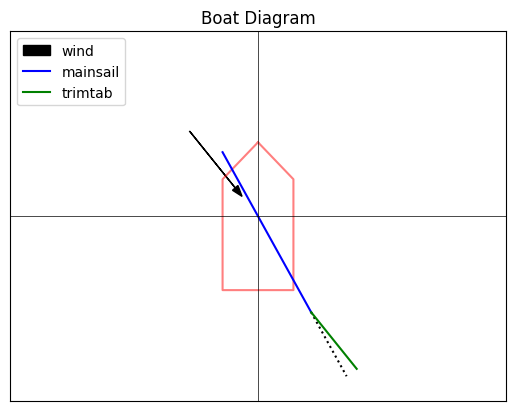

In [66]:
# Determine trimtab angle
reynolds = compute_reynolds_number(apparent_wind_speed)
a = compute_angle_of_attack(reynolds, look_up_table)
t = compute_trim_tab_angle(a, wind_direction)

# print functions
print("Wind speed: ", apparent_wind_speed, " m/s")
print("Wind direction: ", wind_direction, " degrees")
print("Reynolds number: ", round(reynolds, 2))
print("Angle of attack: ", round(a, 2), " degrees")
print("Trim tab angle: ", round(t, 2), " degrees")

# construction and manipulation of wingsail
wingsail = [[0, 2], [0, 0], [0, -3], [0, -5], [0, -3], [0, -5]]
wingsail = rotate_object_around_origin(wingsail, wind_direction)
wingsail = rotate_trimtab(wingsail, t)
wingsail = rotate_object_around_origin(wingsail, -t)

# Drawing commands
drawWind(wind_direction)
drawBoat()
drawSail(wingsail)
showPlot()


## Future Considerations

1. If the wind direction is in a range where the boat is in irons (wind direction is in the no go zone), the angle of
attack should be set to zero. 